In [1]:
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
import re

In [2]:
# download punkt only once
# nltk.download('punkt')

In [4]:
import openai

In [5]:
df= pd.read_csv("conv_sample_posts.csv")

In [6]:
# set the API key
openai.api_key= "

In [7]:
def get_prompts(post):
    """
    Input: post text string
    Output: list of prompts
        'Please provide single word answers to the following questions'
        'Does this post contain text in more than one natural language: {post}?'
        'What is the main natural language?'
        'What is the other natural language?'
    """
    prompt_0= "Please provide single word answers to the questions I'm about to ask"
    prompt_1= f"Does this post contain text in more than one natural language: {post}?"
    prompt_2= "What is the main natural language?"
    prompt_3= "What is the other natural language?"
    
    return [prompt_0, prompt_1, prompt_2, prompt_3]

In [8]:
def get_classifications(post):
    """
    This function performs the ChatGPT API query
    Input: text string
    Output: classification as a string, with commas separating languages
    """
    # get the prompts for the post
    prompts= get_prompts(post)
    
    # Initialize an empty list to hold the conversation messages
    conversation = []

    # Create a loop to add user and model messages to the conversation
    for prompt in prompts:
        user_message = {"role": "user", "content": prompt}
        conversation.append(user_message)

        # Make the API call to get a model response
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=conversation
        )

        # Extract the model's reply and add it to the conversation
        model_reply = response.choices[0].message.content
        conversation.append({"role": "assistant", "content": model_reply})

    # You can now access the conversation for analysis or further processing
    # for message in conversation:
        # print(f"{message['role']}: {message['content']}")
    
    # get the 'content' value from the object, which contains the language classification
    working_language_classification = conversation[5]['content']
    embedded_language_classification = conversation[7]['content']

    # return the classification, which is a string that may contain more than one language, separated by commas
    return working_language_classification, embedded_language_classification

In [9]:
def get_conversation_length(conversation_id):
    """
    Get the total number of posts given a conversation_id
    """
    # Filter the DataFrame to include only rows with the given conversation_id
    filtered_df = df[df['conversation_id'] == conversation_id]
    
    # Get the total number of posts for the conversation_id
    total_posts = len(filtered_df)
    
    return total_posts

In [10]:
def truncate_post(post, n):
    """
    Truncate a string to a maximum number of tokens (n)
    """
    # Tokenize the input string into words
    words = word_tokenize(post)
    
    # Select the first n tokens
    truncated_tokens = words[:n]
    
    # Join the selected tokens back into a string
    truncated_post = ' '.join(truncated_tokens)
    
    return truncated_post

In [11]:
# iterate through a range of conversation data points
for i in range(100):
    
    conversation_id= df.at[i, 'conversation_id']
    print(f"• Examining data point {i}, with conversation_id {conversation_id}")
    
    if pd.isna(df['post_working_language'].iloc[i]) or pd.isna(df['post_embedded_language'].iloc[i]):

        # see how long the conversation is
        conversation_length= get_conversation_length(conversation_id)
        print(f"----Data point {i} is part of a conversation of length {conversation_length}")

        # get the post content
        post= df.at[i, 'post']
        # truncate the post
        truncated_post= truncate_post(post, 25)

        # print out the truncated post
        print(f"--------Post content: {truncated_post}")

        # get the language classification for the text
        print(f"--------Getting the language classification...")
        working_language_classification, embedded_language_classification= get_classifications(truncated_post) # <- HERE IS WHERE THE API QUERY TAKES PLACE
        
        print(f"--------Working language is: {working_language_classification}")
        print(f"--------Embedded language is: {embedded_language_classification}")

        # associate the languages with the conversation data point in a new column
        df.loc[i, "post_working_language"]= working_language_classification
        df.loc[i, "post_embedded_language"]= embedded_language_classification

        print("\n")
    
    else:
        print(f"----Data point {i} already has a working and embedded language classifications!")
        
# Specify the path where you want to save the CSV file
file_path = 'conv_sample_posts.csv'

# Save the DataFrame to a CSV file
df.to_csv(file_path, index=False)  # Set index=False to exclude the index column

print(f'DataFrame has been saved to {file_path}')

• Examining data point 0, with conversation_id 0
----Data point 0 already has a working and embedded language classifications!
• Examining data point 1, with conversation_id 1
----Data point 1 already has a working and embedded language classifications!
• Examining data point 2, with conversation_id 1
----Data point 2 already has a working and embedded language classifications!
• Examining data point 3, with conversation_id 1
----Data point 3 already has a working and embedded language classifications!
• Examining data point 4, with conversation_id 1
----Data point 4 already has a working and embedded language classifications!
• Examining data point 5, with conversation_id 1
----Data point 5 already has a working and embedded language classifications!
• Examining data point 6, with conversation_id 2
----Data point 6 already has a working and embedded language classifications!
• Examining data point 7, with conversation_id 2
----Data point 7 already has a working and embedded language c

--------Working language is: English.
--------Embedded language is: I'm sorry, but I can't determine the other natural language without more context. Can you please provide more information?


• Examining data point 29, with conversation_id 3
----Data point 29 is part of a conversation of length 20
--------Post content: Going to close this since it 's merged to master and the upstream issue is closed now . @ crimsonhawk47 If you still have the
--------Getting the language classification...
--------Working language is: English.
--------Embedded language is: There is no other natural language identified in the given text.


• Examining data point 30, with conversation_id 4
----Data point 30 is part of a conversation of length 1
--------Post content: < ! -- CLA-CHECK:130 -- > & # 10060 ; Author of the following commits did not sign a [ Contributor Agreement ] ( https
--------Getting the language classification...
--------Working language is: English
--------Embedded language is: There is 

--------Working language is: English.
--------Embedded language is: There is no other natural language.


• Examining data point 48, with conversation_id 8
----Data point 48 is part of a conversation of length 39
--------Post content: Awaiting bors try build completion . @ rustbot label : +S-waiting-on-perf
--------Getting the language classification...
--------Working language is: English.
--------Embedded language is: There isn't another natural language.


• Examining data point 49, with conversation_id 8
----Data point 49 is part of a conversation of length 39
--------Post content: : hourglass : Trying commit 7738cc734546bc91ede24376970cc4dfd01580da with merge 4997a56cf2edc4b2be488f2f2b586bf5e2bb3b37 ... < ! -- homu : { `` type '' : '' TryBuildStarted '' , ''
--------Getting the language classification...
--------Working language is: English
--------Embedded language is: None


• Examining data point 50, with conversation_id 8
----Data point 50 is part of a conversation of length 3

--------Working language is: English.
--------Embedded language is: There is no other natural language.


• Examining data point 68, with conversation_id 8
----Data point 68 is part of a conversation of length 39
--------Post content: : umbrella : The latest upstream changes ( presumably # 105644 ) made this pull request unmergeable . Please [ resolve the merge conflicts ]
--------Getting the language classification...
--------Working language is: English
--------Embedded language is: None


• Examining data point 69, with conversation_id 8
----Data point 69 is part of a conversation of length 39
--------Post content: : umbrella : The latest upstream changes ( presumably # 105612 ) made this pull request unmergeable . Please [ resolve the merge conflicts ]
--------Getting the language classification...
--------Working language is: English.
--------Embedded language is: None.


• Examining data point 70, with conversation_id 8
----Data point 70 is part of a conversation of length 39
---

--------Working language is: English.
--------Embedded language is: There is no other natural language mentioned in the post.


• Examining data point 88, with conversation_id 19
----Data point 88 is part of a conversation of length 1
--------Post content: Successfully deployed to the following URLs : # # media-flags – ./ [ media-flags.vercel.app ] ( https : //media-flags.vercel.app ) [ media-flags-respectad1k.vercel.app ] ( https
--------Getting the language classification...
--------Working language is: English.
--------Embedded language is: No.


• Examining data point 89, with conversation_id 20
----Data point 89 is part of a conversation of length 1
--------Post content: Bump certifi from 2019.6.16 to 2022.12.7 . Bumps [ certifi ] ( https : //github.com/certifi/python-certifi ) from 2019.6.16 to 2022.12.7 . < details > <
--------Getting the language classification...
--------Working language is: English
--------Embedded language is: None


• Examining data point 90, with conversat

In [12]:
# Set the max_rows option temporarily to display all 100 rows
with pd.option_context('display.max_rows', None):
    display(df.head(100))

,conversation_id,post,post_working_language,post_embedded_language,post_working_language_actual
0,0,Update dependency @testing-library/user-event ...,English.,No other natural language.,English
1,1,I would like to work on this issue,English.,There is no other natural language.,English
2,1,go for it!,English.,None.,English
3,1,Looks like there is a potential PoC and Docker...,English,None,English
4,1,After looking into this further I think it wil...,English.,There is no other natural language specified i...,English
5,1,I spoke with @catc0n about this and she had ag...,English.,Unknown.,English
6,2,Expand support for indirections. 1) Implement ...,English,NA (Not applicable),English
7,2,"can you explain why we dont need this anymore,...",English.,There was no other natural language detected i...,English
8,2,The flag is only relevant for stores i. e. `ST...,English,None,English
9,2,"oh yes, thanks",English.,None.,English


## Identifying embedded languages

Issues:
- How do we control for programming languages
- Why does the model give opposite answers for the same question (see Korean data point)
- We can use regex to change all reponses containing "no", "none", etc. to "None"
- We can easily clean up the punctuation

Observations:
- Main language is correctly identified 100% of the time
- Embedded language was incorrectly classified 1% of the time, but it was an important one containing embedded English in Korean

In [14]:
df.post[94]

'그럼 required는 빼야 하지 않을까요?'

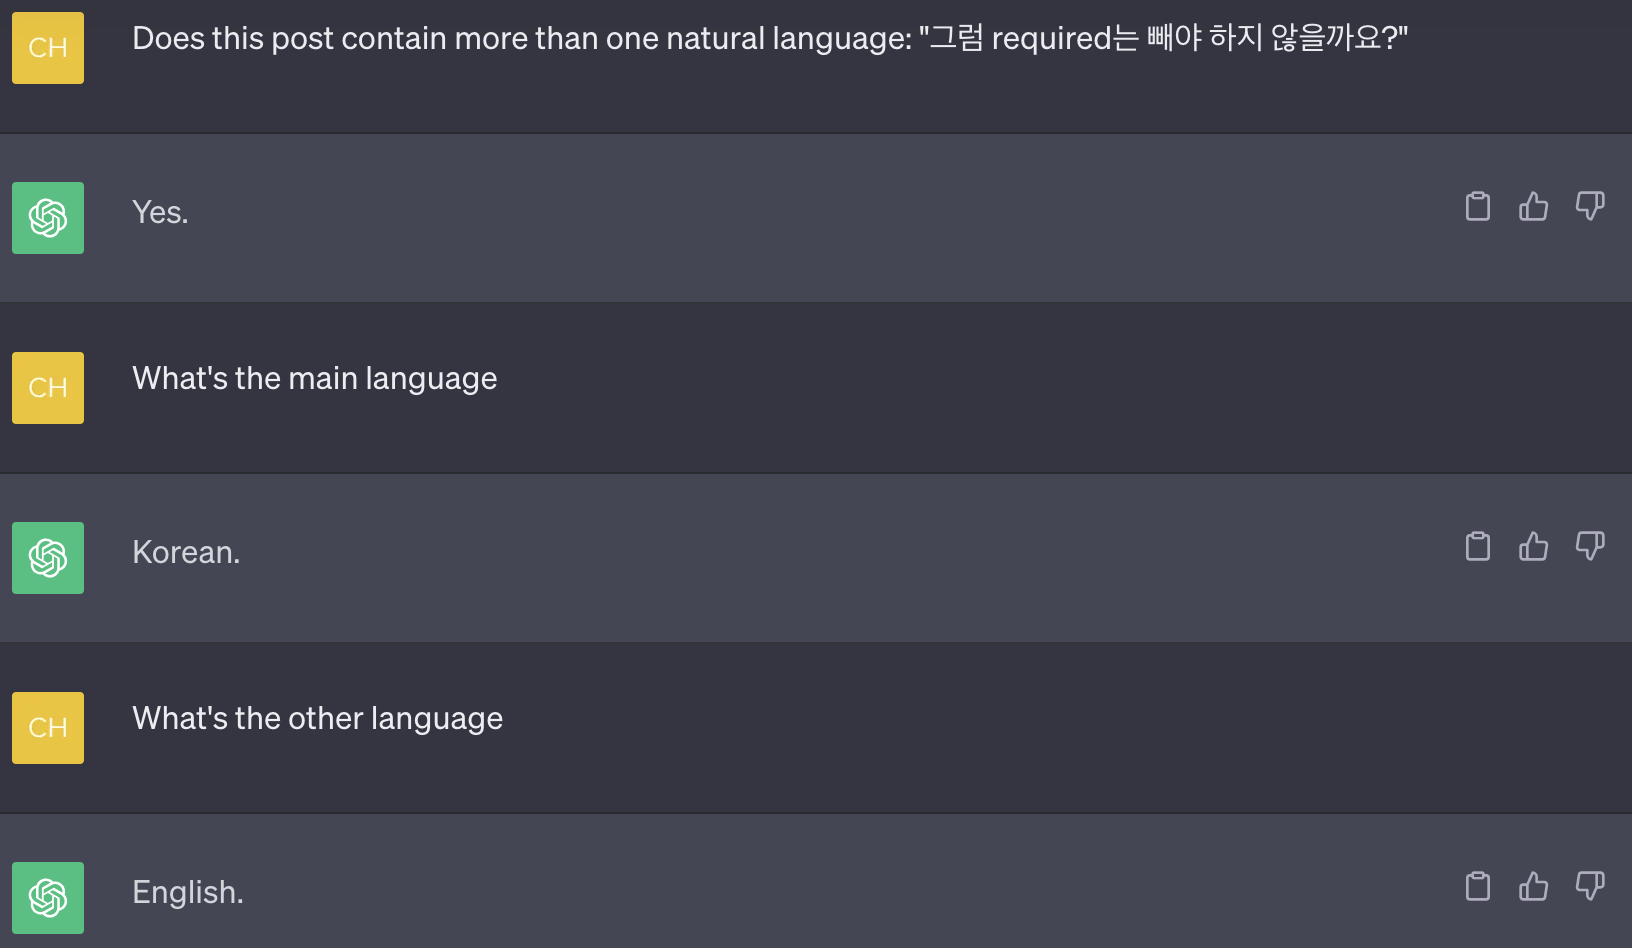

New approach to try: for each post, prompt ChatGPT twice:
once for the main language, and again for additional languages, rather than getting all the main languages, then going back and getting all the additional/embedded languages

- Extract the languages, combine the answer with the prompt
- Ask for the number of languages, if > 1, proceed with getting embedded languages
- 1000 queries, evaluate accuracy
- ChatGPT classification versus traditional